In [2]:
# REFRESH S3 Creds
import requests
import os

username = os.environ["DG_USER"]
password = os.environ["DG_PASSWORD"]
api_key = os.environ["DG_API_KEY"]
    
def get_token(): 
    url = 'https://geobigdata.io/auth/v1/oauth/token/'
    headers = {"Authorization": "Basic " + api_key, "Content-Type": "application/x-www-form-urlencoded"}
    params = {"grant_type": "password", "username": username, "password": password }
    results = requests.post(url, headers=headers, data=params)
    return results.json()['access_token']

def get_s3_creds():
    url     = 'https://geobigdata.io/s3creds/v1/prefix?duration=36000'
    headers = {'Content-Type': 'application/json',"Authorization": "Bearer " + get_token()}
    return requests.get(url,headers=headers).json()
        
#print get_token()
c = get_s3_creds()
os.environ["export AWS_ACCESS_KEY_ID"]= c['S3_access_key']
os.environ["AWS_SECRET_ACCESS_KEY"] = c['S3_secret_key']
os.environ["AWS_SESSION_TOKEN"] = c['S3_session_token']
print "All set"

All set


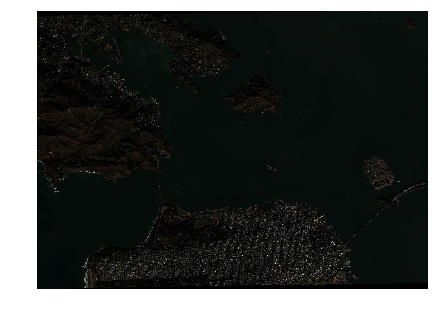

In [4]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import rasterio
import cv2

%matplotlib inline

def render(arr1, arr2=None, width=7, height=7, cmap=plt.cm.jet):
    if arr2 is None:
        fig, ax = plt.subplots(1, figsize=(width,height), facecolor='white')
        ax.axis('off')
        plt.imshow(arr1, cmap=cmap)
        plt.show()
    else: 
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(width, height)
        ax1.imshow(arr2, cmap=cmap)
        ax1.axis('off')
        ax2.imshow(arr1)
        ax2.axis('off')

with rasterio.drivers():
    #with rasterio.open('s3://gbd-customer-data/eb379ee5-2c35-4832-a757-a6b3535f2883/2014_sf/054813633010_01/054813633010_01_P001_PAN/14JAN01192007-P1BS-054813633010_01_P001.TIF') as src:
    with rasterio.open('/Users/chelm/dev/timbr/notebooks/data/acomp_sf_2014.tif') as src:
        b, g, r = (src.read(k) for k in (2, 3, 5))
        
img = np.dstack([r,g,b])
img = cv2.convertScaleAbs(img, alpha=(255.0/r.max()))
render(img)
        

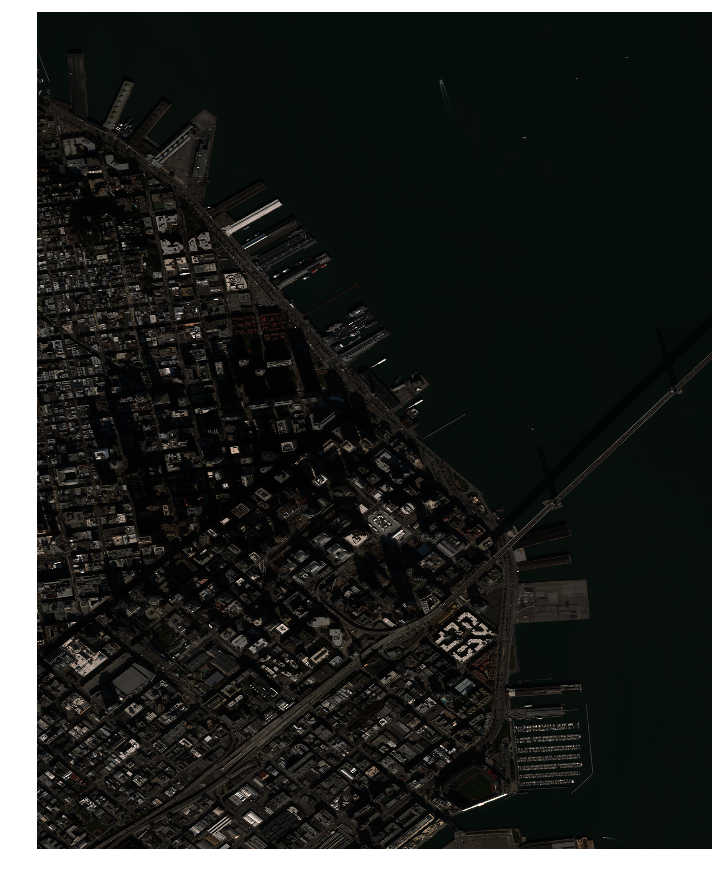

In [6]:
import os
import rasterio

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_ubyte

def clip_image(bbox, filepath):
    with rasterio.drivers():
        with rasterio.open(filepath) as raster:
            #bounds = src.bounds
            ul = raster.index(*bbox[0:2])
            lr = raster.index(*bbox[2:4])
            window = ((lr[0], ul[0]+1), (ul[1], lr[1]+1))
            bands = [raster.read(b, window=window) for b in (5,3,2)] 
            return bands

bbox = [-122.408119,37.775797,-122.379112,37.811818]
#bbox = [-122.416449, 37.777346, -122.387288, 37.792931]

bands = clip_image(bbox, '/Users/chelm/dev/timbr/notebooks/data/acomp_sf_2014.tif')        
red = bands[0]
blue = bands[2]
green = bands[1]

image = np.dstack((red,green,blue))
image -= red.min()
image //= (image.max() - image.min()) / 255

render(image.astype(np.uint8), width=15, height=15)


In [7]:
from ipyleaflet import Map, GeoJSON
import sys
import json

import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
import numpy as np

import json 

def create_map():
    with open('./data/sf_parcels.json') as f:
        data = json.load(f)
    
        def data_to_colors(data, colormap=mpl.cm.spec):
            c = [mpl.colors.rgb2hex(d[0:3]) for d in colormap(mpl.colors.Normalize()(data))]
            return c
        
        def n_colors(n, colormap=mpl.cm.Blues):
            data = np.linspace(0.0,1.0,n)
            c = [mpl.colors.rgb2hex(d[0:3]) for d in colormap(data)]
            return c

        keys = [f['properties']['LANDUSE'] for f in data['features']]
        colors = dict(zip(keys, n_colors(len(keys))))
        #print colors
        lon,lat = -122.401868,37.785139
        m = Map(center=[lat, lon], zoom=14)
        for f in data['features']:
            f['properties']['style'] = {'color':'#08c', 'weight': 0, 'fillColor':'#08c', 'fillOpacity':1}
    
        g = GeoJSON(data={'features': data['features']})
        m.add_layer(g)
        return m
    
create_map()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [8]:
import rasterio
import rasterio.features
from affine import Affine
from shapely.geometry import shape
import numpy as np

import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
import numpy as np

import json 

def zonal_stats(geojson, tif, bbox=None, NIR_Red=None):
    with open(geojson) as f:
        data = json.load(f)
        with rasterio.open( tif, 'r') as raster:
            window = None
            if bbox is not None:
                ul = raster.index(*bbox[0:2])
                lr = raster.index(*bbox[2:4])
                window = ((lr[0], ul[0]+1), (ul[1], lr[1]+1))
                
            bands = raster.read(window=window).astype(np.float32)
            
            for i, feature in enumerate(data['features']):
                geometry = shape(feature['geometry'])
                ul = raster.index(*geometry.bounds[0:2])
                lr = raster.index(*geometry.bounds[2:4])

                t = raster.affine
                shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

                stats = []
                for band in bands:
                    window = band[lr[0]: ul[0]+1, ul[1]:lr[1]+1]
                    try: 
                        mask = rasterio.features.rasterize(
                            [(geometry, 0)],
                            out_shape = window.shape,
                            transform = shifted_affine,
                            fill = 1,
                            all_touched = True,
                            dtype = np.uint8)

                        masked_data = np.ma.array(data=window, mask=mask.astype(bool))

                        stats.append({
                            'min':  window.min(),
                            'mean': window.mean(),
                            'median': np.median(window),
                            'max': window.max()})
                    except:
                        pass
                    
                # compute indices
                if NIR_Red is not None: 
                    NIR = bands[NIR_Red[0]][lr[0]: ul[0]+1, ul[1]:lr[1]+1]
                    Red = bands[NIR_Red[1]][lr[0]: ul[0]+1, ul[1]:lr[1]+1]
                    feature['properties']['ndvi'] = np.nanmean((NIR - Red)/(NIR + Red))
                
                feature['properties']['stats'] = stats
    return data

def data_to_colors(data, colormap=mpl.cm.Reds):
    c = [mpl.colors.rgb2hex(d[0:3]) for d in colormap(mpl.colors.Normalize()(data))]
    return c

def show_map(features, vals, lat, lon, zoom, band, stat, colormap=mpl.cm.rainbow):
    #vals = [f['properties']['stats'][band][stat] for f in features]
    colors = data_to_colors(vals, colormap=colormap)
   
    for feature, color in zip(features, colors):
        feature['properties']['style'] = {'color':color, 'weight': 0, 'fillColor':color, 'fillOpacity':1}

    m = Map(center=[lat, lon], zoom=zoom)
    g = GeoJSON(data={'features': features})
    m.add_layer(g)
    return m



# Path to geojson to compute zonal stats on
geojson = './data/sf_parcels.json'

# path to the tif to use
tif = './data/acomp_sf_2014.tif'

# the band indices for the NIR_Red channel for NDVI
NIR_Red = (6,4)

# collect band stats for each polygon for any tif
geodata = zonal_stats(geojson, tif, NIR_Red=NIR_Red)


lon, lat = -122.401868, 37.785139
zoom = 15
#vals = [f['properties']['stats'][band][stat] for f in features]
vals = [f['properties']['ndvi'] for f in geodata['features']]
lmap = show_map(geodata['features'], vals, lat, lon, zoom, 6, 'mean')

lmap

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


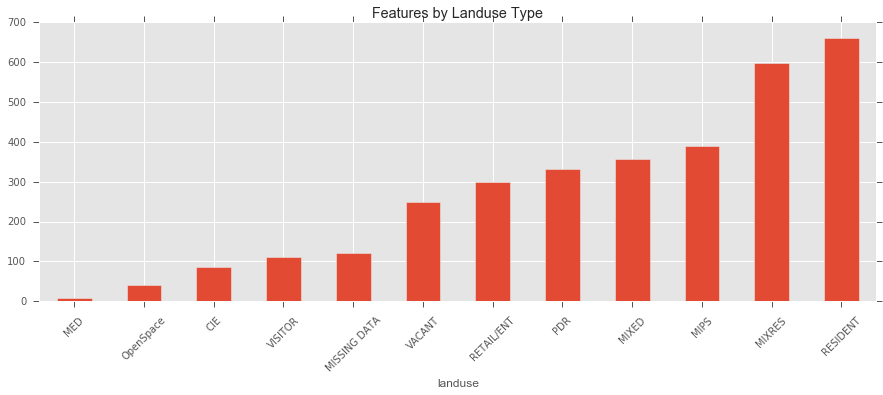

In [12]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
%matplotlib inline

stats = pd.DataFrame.from_records([
        (f['properties']['LANDUSE'], f['properties']['stats'], f['properties']['ndvi']) 
        for f in geodata['features']], columns=['landuse', 'stats', 'ndvi'])

landuse = stats.groupby('landuse')
landuse.size().sort_values().plot(kind='bar', figsize=(15, 5), rot=45, title='Features by Landuse Type')
plt.show()

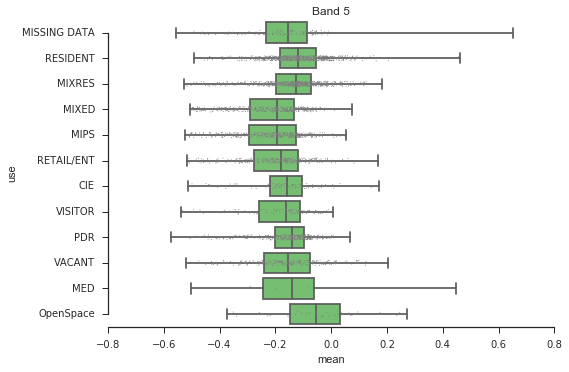

In [14]:

import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

def boxplot( stats, band ):
    means = [(stats['landuse'][i], stats['ndvi'][i]) for i in stats.index]
    band_means = pd.DataFrame.from_records(means, columns=['use', 'mean'])
    ax = sns.boxplot(x="mean", y="use", data=band_means,
                 whis=np.inf, color="g")
    sns.stripplot(x="mean", y="use", data=band_means,
              jitter=True, size=1, color=".5", linewidth=0)
    ax.set_title('Band '+str(band+1))
    sns.despine(trim=True)
    
boxplot(stats, 4)


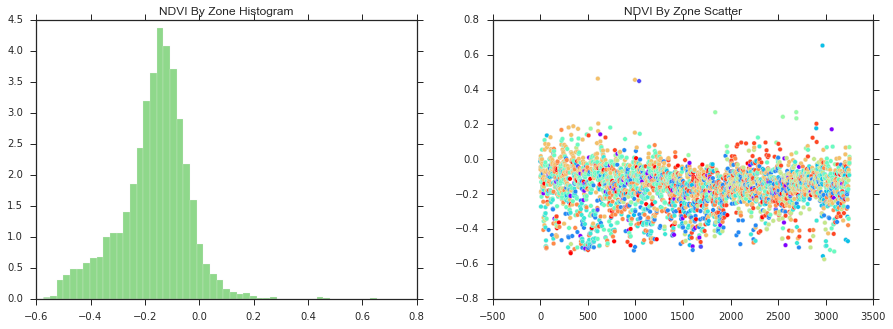

In [16]:
def n_colors(n, colormap=mpl.cm.rainbow):
    data = np.linspace(0.0,1.0,n)
    c = [mpl.colors.rgb2hex(d[0:3]) for d in colormap(data)]
    return c

keys = landuse['landuse'].size().index
colors = dict(zip(keys, n_colors(len(keys))))

def plot_band( df, band, title=None ):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.set_title(title + ' Histogram')
    #n, bins, patches = ax1.hist([df['stats'][i][band]['mean'] for i in df.index], 50, normed=1, facecolor='g', alpha=0.75)
    n, bins, patches = ax1.hist([df['ndvi'][i] for i in df.index], 50, normed=1, facecolor='g', alpha=0.75)
    ax2.set_title(title + ' Scatter')
    ax2.scatter(list(df.index), [df['ndvi'][i] for i in df.index], c=[colors[df['landuse'][i]] for i in df.index])
    #ax2.scatter(list(df.index), [df['stats'][i][band]['mean'] for i in df.index], c=[colors[df['landuse'][i]] for i in df.index])
    plt.show()

#for b in range(0,8):   
#    plot_band( stats, b, title="Band "+str(b+1))

plot_band( stats, 4, title="NDVI By Zone")


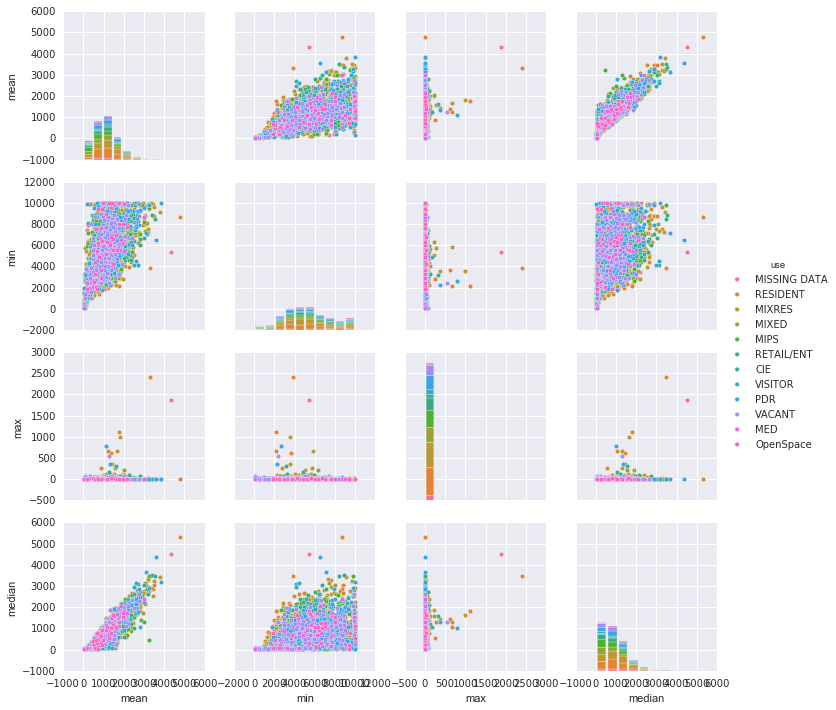

In [17]:
import seaborn as sns
sns.set()

def band_pair_plot(band):
    vals = []
    for i in stats.index:
        vals.append((
                stats['landuse'][i], 
                stats['stats'][i][band]['mean'], 
                stats['stats'][i][band]['max'],
                stats['stats'][i][band]['min'],
                stats['stats'][i][band]['median']
            ))

    band_df = pd.DataFrame.from_records(vals, columns=['use', 'mean', 'min', 'max', 'median'])
    sns.pairplot(band_df, hue="use")

#band_pair_plot(0)
band_pair_plot(7)